# Tweets Sentiment Analysis Baseline

## 一、使用TFIDF+SVM进行情感分析

### 1.导入相应的包并读取数据

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import recall_score,precision_score,roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from scipy import interp

In [2]:
# 读取数据
data = pd.read_csv('./data/data.csv')

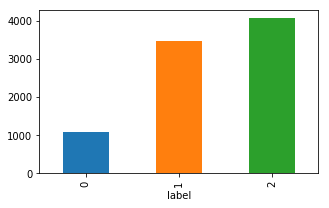

In [3]:
data.groupby('label')['label'].size().plot(kind='bar', figsize=(5, 3))

In [4]:
data.count()

label    8625
tweet    8625
dtype: int64

## 2.切分数据集，分为训练集和验证集

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(data['tweet'],data['label'],test_size= 0.1,random_state=42)

## 3.使用TFIDF来提取推文中的特征并使用 LinearSVC进行分类

In [6]:
def TFIDF_LinearSVC(X_train,X_test,Y_train):
        # 使用TFIDF提取特征
        vectorizer = TfidfVectorizer(ngram_range=(1, 2))
        # 构造tfidf矩阵
        vectorizer.fit(data['tweet'])
        # 构造训练集的tfidf矩阵
        x_train = vectorizer.transform(X_train)
        # 构造测试的tfidf矩阵
        x_test = vectorizer.transform(X_test)
        y_train = Y_train
        # 实例化 LinearSVC模型
        classifier = LinearSVC() 
        # 模型训练，传入训练集及其标签
        classifier.fit(x_train, y_train)
        # 根据上面训练好的分类器对测试集的每个样本类别进行预测
        y_scores = classifier.decision_function(x_test)
        y_classes = y_scores.argmax(axis=-1)
        return y_scores,y_classes

In [7]:
# 得到每个样本对应类别的预测分数及预测类别
y_scores, y_classes = TFIDF_LinearSVC(X_train,X_test,Y_train)

## 4.计算Precision、recall、ROC

### 1、计算Precision、Recall

In [8]:
# 精确度和召回率
def Precision_Recall(Y_test, y_classes):
    precision = precision_score(Y_test, y_classes, average='macro')
    recall = recall_score(Y_test,y_classes,average='macro')
    return precision,recall

In [9]:
precision,recall = Precision_Recall(Y_test, y_classes)
print('The precision score is: ',precision)
print('The recall score is: ',recall)

The precision score is:  0.8024315088080533
The recall score is:  0.6844276833777357


### 2.计算ROC  &  AUC

In [10]:
def ROC_and_AUC(Y_test,y_scores):
        # 将测试样本真实的标签二值化
        Y_test = label_binarize(Y_test, classes=[0, 1, 2])
        # 设置n_classes参数，其值为类别个数
        n_classes = 3
        # 计算每一类的ROC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        n_classes
        # Plot all ROC curves
        lw=2
        plt.figure()
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)
        
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))
        
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

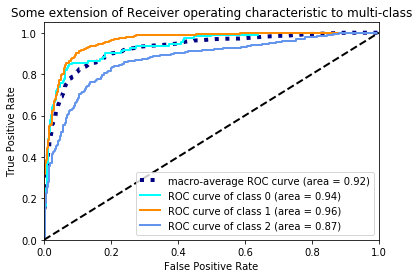

In [11]:
ROC_and_AUC(Y_test,y_scores)